In [1]:
import xarray as xr
from cdo import Cdo
cdo = Cdo()
import sys
sys.path.append("/home/abhi/Documents/mygit/postBC_diagnostic/src/scripts")
from recipes import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')
import pandas as pd

In [2]:
from scipy.stats import genextreme as gev
import numpy as np
from scipy.stats import ks_2samp

In [3]:
data_dir = "/home/abhi/Documents/data/"
obs = f'{data_dir}/OBSERVATION/IMD/precip/1901-2017_ll25.nc'

In [4]:
ann_max_seas = cdo.yearmax(input=f'-selseas,JJAS {obs}', returnCDF=True)

In [5]:
ds = xr.open_dataset(ann_max_seas).mean(dim='bnds').drop('time_bnds')

/home/abhi/miniconda3/lib/python3.6/site-packages/xarray/core/nanops.py:162: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
ds_region = {}

In [7]:
ds_region['1971-2000'] = selyear(sellonlatbox(ds, [73, 76, 18, 21]), years=range(1971, 2001))
ds_region['1941-1970'] = selyear(sellonlatbox(ds, [73, 76, 18, 21]), years=range(1941, 1971))

In [8]:
df = pd.DataFrame({key: np.histogram(ds_region[key].rf.values.flatten(),
                                     bins=np.arange(0, 410, 10), density=True)[0]
              for key in ds_region.keys()})


In [9]:
df.set_index(np.arange(5, 405, 10), inplace=True)

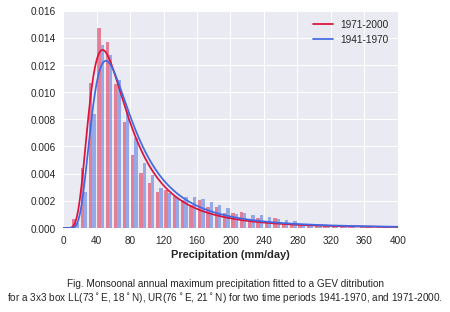

In [118]:
fig, ax = plt.subplots()

ax.set_xlim(0, 400)
ax.set_ylim(0, 0.016)
colors = iter(['crimson', 'royalblue'])

for key, value in ds_region.items():
    region_vals = value.rf.values.flatten()

    shp, loc, scl = gev.fit(region_vals)

    x_grid = np.linspace(0, 400, 200)
    region_pdf = gev.pdf(x_grid, loc=loc, scale=scl, c=shp)

    ax.plot(x_grid, region_pdf, label=key, color=next(colors))
    ax.plot
    
ax.legend()
ax.set_xticks(np.arange(0, 420, 40))

ax.bar(df.index-2, df['1971-2000'], width=4, color='crimson', alpha=0.5)
ax.bar(df.index+2, df['1941-1970'], width=4, color='royalblue', alpha=0.5)

ax.set_xlabel('Precipitation (mm/day)', fontweight='bold')\

caption = fig.text(0.5, -0.1,
                   'Fig. Monsoonal annual maximum precipitation fitted to a GEV ditribution\n'+\
                   'for a 3x3 box LL(73$^\circ$E, 18$^\circ$N), UR(76$^\circ$E, 21$^\circ$N) '+\
                   'for two time periods 1941-1970, and 1971-2000.',
                   ha='center', va='center')

fig.savefig("../output/gev_blockmax_precip2.png", dpi=400, bbox_inches='tight')

### Analysing the JJAS annual maximum precipitation distribution over the Western ghats region accross time slices

In [37]:
import geopandas as gpd
import salem
shp = gpd.read_file("/home/abhi/Documents/data/shapefiles/India_climatic_correct/India_climatic_correct.shp")

In [44]:
shp.index.name = 'Region'

In [47]:
shp.index

RangeIndex(start=0, stop=8, step=1, name='Region')

In [ ]:
ds = xr.concat([ds.salem.roi(shape=shp.loc[shp.index == index]) 
                         for index in shp.index], 
              dim=shp.index).rename({'concat_dim': 'Region'})

In [48]:
ds

<xarray.Dataset>
Dimensions:     (Id: 8, Region: 8, concat_dim: 8, lat: 129, lon: 135, time: 117)
Coordinates:
  * time        (time) datetime64[ns] 1901-07-31T12:00:00 ... 2017-07-31T12:00:00
  * lon         (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat         (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
  * Id          (Id) int64 1 2 3 4 5 6 7 8
  * concat_dim  (concat_dim) int64 0 1 2 3 4 5 6 7
  * Region      (Region) int64 0 1 2 3 4 5 6 7
Data variables:
    rf          (Region, concat_dim, Id, time, lat, lon) float32 nan nan ... nan
Attributes:
    pyproj_srs:  +units=m +proj=latlong +datum=WGS84 

In [41]:
ds.sel(Id=6).mean(dim="time").rf

<xarray.DataArray 'rf' (concat_dim: 8, lat: 129, lon: 135)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       ...,

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * lon         (lon) float64 66.5 66.75 67.0 67.25 ... 99.25 99.5 99.75 100.0
  * lat         (lat) float64 6.5 6.75 7.0 7.25 7.5 ... 37.75 38.0 38.25 38.5
    Id          int64 6
  * concat_dim  (concat_dim) int64 0 1 2 3 4 5 6 7

### Bootstrapped confidence intervals of maximum likelihood estimated parameters for GEV distribution

In [134]:
%%time 

sample_size = 100
num_draws = 1000

btstrp_dict = {'shp': [], 'loc': [], 'scl': []}
for draw in range(num_draws):
    rvs = gev.rvs(loc=loc, scale=scl, c=shp, size=sample_size)
    
    shp, loc, scl = gev.fit(rvs)
    for param in ['shp', 'loc', 'scl']:
        btstrp_dict[param].append(eval(param))

/home/abhi/miniconda3/lib/python3.6/site-packages/scipy/stats/_continuous_distns.py:2276: RuntimeWarning: invalid value encountered in subtract
  -pex2+logpex2-logex2)


CPU times: user 2min 41s, sys: 780 ms, total: 2min 42s
Wall time: 2min 42s


In [135]:
btstrp_df = pd.DataFrame(btstrp_dict)

In [146]:
btstrp_df.describe(percentiles=[.025, .975], ).loc[['2.5%', '97.5%'], :]

,shp,loc,scl
2.5%,-0.319677,30.289258,0.000010
97.5%,1.245993,30.404829,0.148321


In [143]:
shp, loc, scl

(1.2508483148595988, 30.34190953564741, 1.2131351836962896e-05)

In [59]:
from scipy import stats

In [61]:
stats.ttest_ind(ds_region['1971-2000'].rf.values.flatten(),
                ds_region['1941-1970'].rf.values.flatten())

Ttest_indResult(statistic=-6.197419743943228, pvalue=5.962862182910381e-10)

In [63]:
ds_region['1941-1970'].rf.values.flatten().mean()

95.83927

In [39]:
ks_2samp(ds_region['1971-2000'].rf.values.flatten(),
         ds_region['1941-1970'].rf.values.flatten())

Ks_2sampResult(statistic=0.06804733727810652, pvalue=1.1372184518685225e-10)

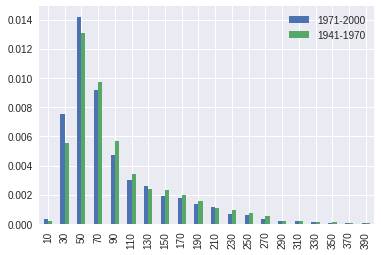

In [56]:
df.plot(kind='bar')


<BarContainer object of 20 artists>

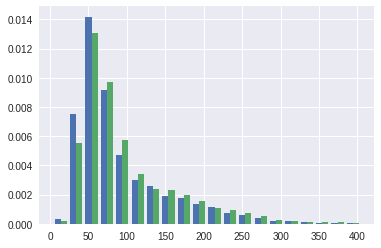

In [73]:
fig, ax = plt.subplots()

ax.bar(df.index, df['1971-2000'], width=8)
ax.bar(df.index+8, df['1941-1970'], width=8)

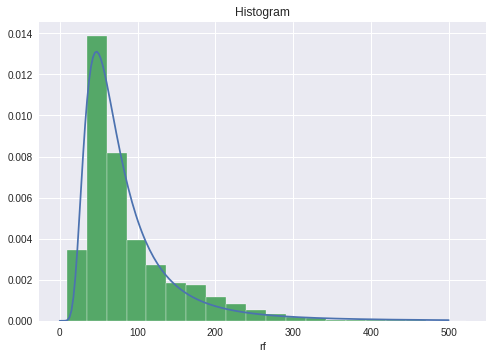

In [77]:
region_vals = ds_region_y1.rf.values.flatten()

shp, loc, scl = gev.fit(region_vals)

x_grid = np.linspace(0, 500, 200)
region_pdf = gev.pdf(x_grid, loc=loc, scale=scl, c=shp)

plt.plot(x_grid, region_pdf)
histplot = ds_region.rf.plot.hist(bins=20, edgecolor='white', density=True)

region_vals = ds_region.rf.values.flatten()

shp, loc, scl = gev.fit(region_vals)

x_grid = np.linspace(0, 500, 200)
region_pdf = gev.pdf(x_grid, loc=loc, scale=scl, c=shp)

plt.plot(x_grid, region_pdf)
histplot = ds_region.rf.plot.hist(bins=20, edgecolor='white', density=True)